# **- Starter Code**

In [ ]:
#Starter Code
import matplotlib.pyplot as plt
import glob
from PIL import Image,ImageOps
import numpy as np
import os

# **- Given Functions**

In [ ]:
#Function 1: Given an image, returns the image and it's squared version in array format
def toArrayAndSquare(im):
  img = [[0 for x in range(im.size[0])] for y in range(im.size[1])]
  sqr = [[0 for x in range(im.size[0])] for y in range(im.size[1])]
  for i in range (0,im.size[0]):
    for j in range (0,im.size[1]):
      img[j][i] = im.getpixel((i,j))
      sqr[j][i] = img[j][i] ** 2
  return img,sqr



#Function 2: Given an image, applies a certain threshold
def applyThreshold(im, th):
  res = [[0 for x in range(len(im[0]))] for y in range(len(im))]
  for i in range (0,len(im)):
    for j in range (0,len(im[0])):
      if(im[i][j]<th):
        res[i][j] = 0
      else:
        res[i][j] = 255
  return res

# Task 1

In [ ]:
## getting the image and converting it to grey scale
image = Image.open('sample_image.jpg')
image = image.convert('L')
image.show()

In [ ]:
image_array = toArrayAndSquare(image)

In [ ]:
#extracting the image array
image_array = image_array[0]

In [ ]:
def calculateCooccurrence(image_array, isHorizontal):
    cooccurence_matrix = np.zeros((256, 256))
    if(isHorizontal):
        for i in range(len(image_array)):
            for j in range(len(image_array[0]) - 1):
                cooccurence_matrix[image_array[i][j]][image_array[i][j+1]]+=1
    else:
         for i in range(len(image_array[0])):
            for j in range(len(image_array) - 1):
                cooccurence_matrix[image_array[j][i]][image_array[j+1][i]]+=1                
    return cooccurence_matrix

In [ ]:
cooccurence_matrix_horizontal = calculateCooccurrence(image_array, True)

In [ ]:
cooccurence_matrix_vertical = calculateCooccurrence(image_array, False)

In [ ]:
#Because the array is passed by reference
import copy

In [ ]:
def nullifyPixels(cooccurence_matrix, threshold):
    nullified = cooccurence_matrix.copy()
    #first line equation:   y = x + intercept
    #Second line equation:  y = x - intercept
    #In order to nullify the pixel it should lay below the first line and above the second one
    matrix_length = len(nullified);
    intercept = threshold
    for i in range(matrix_length):
        for j in range(matrix_length):
            if isPixelAboveTheLine(i,j,intercept) or not isPixelAboveTheLine(i,j,-intercept):
                continue
            nullified[i][j] = 0
    return nullified

In [ ]:
def isPixelAboveTheLine(x,y,intercept):
    y_on_the_line = x + intercept
    if y > y_on_the_line :
        return True
    else:
        return False;

In [ ]:
cooccurence_matrix_horizontal_nullified = nullifyPixels(cooccurence_matrix_horizontal, 30)

In [ ]:
cooccurence_matrix_vertical_nullified = nullifyPixels(cooccurence_matrix_vertical, 30)

In [ ]:
def imgWithCooccurrence (im, southNorthMatrix, eastWestMatrix):
    counter = 0
    res = [[0 for x in range(len(im[0]))] for y in range(len(im))]
    for i in range (0,len(im)-1):
        for j in range (0,len(im[0])-1):
            currentPixel = im[i][j]
            eastPixel = im[i][j+1]
            southPixel = im[i+1][j]    
            if(southNorthMatrix[currentPixel][southPixel] > 0 or eastWestMatrix[currentPixel][eastPixel] > 0):
                counter+=1
                res[i][j] = 255
            else:
                res[i][j] = 0
    print(counter)
    return res

In [ ]:
reconstructed_image = imgWithCooccurrence(image_array,cooccurence_matrix_vertical_nullified, cooccurence_matrix_horizontal_nullified)

10841


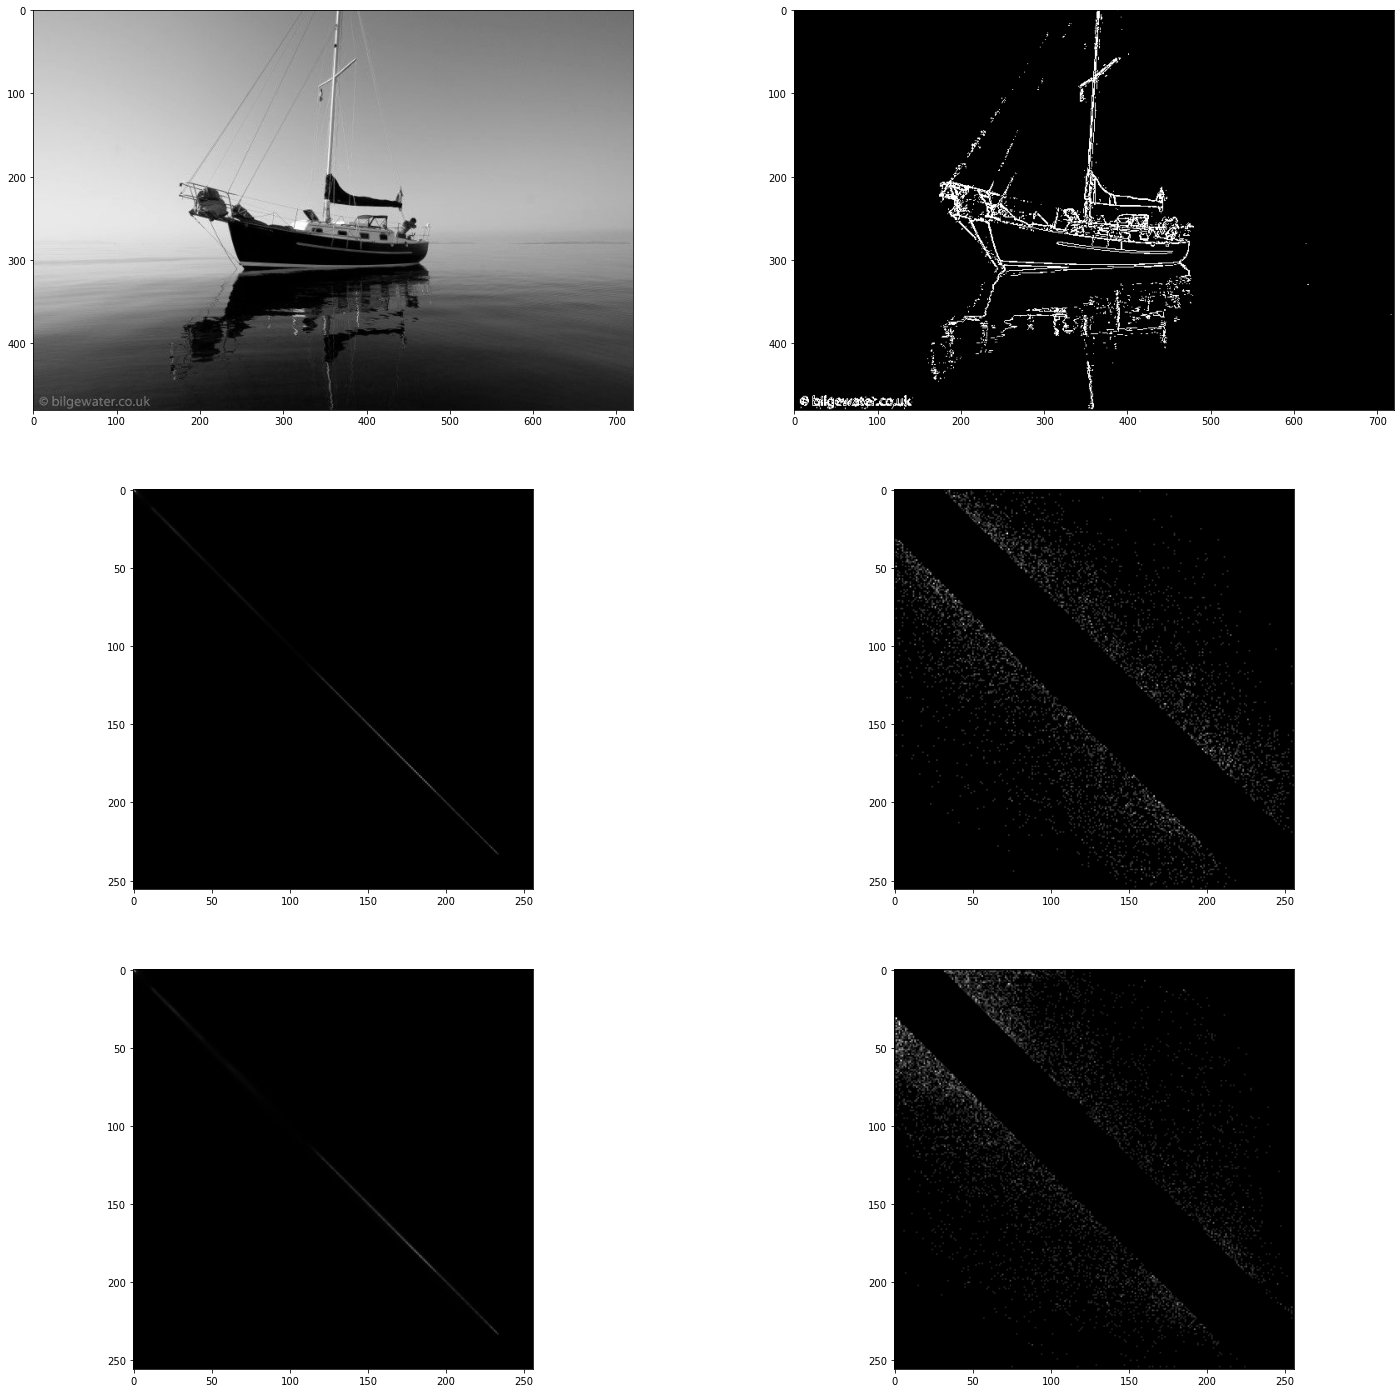

In [ ]:

#plt has to be imported, see the previous sections
plt.subplots(nrows=3, ncols=2, figsize=(25, 25))

plt.subplot(3,2,1)
plt.imshow(image,  cmap = 'gray')

plt.subplot(3,2,2)
plt.imshow(reconstructed_image,  cmap = 'gray')

plt.subplot(3,2,3)
plt.imshow(cooccurence_matrix_horizontal,  cmap = 'gray')

plt.subplot(3,2,4)
plt.imshow(cooccurence_matrix_horizontal_nullified,  cmap = 'gray')

plt.subplot(3,2,5)
plt.imshow(cooccurence_matrix_vertical,  cmap = 'gray')

plt.subplot(3,2,6)
plt.imshow(cooccurence_matrix_vertical_nullified,  cmap = 'gray')

# Task 2

In [ ]:
def integralArray(im):
  #creating numpy array with the same shape as image
  integral = np.array([[0 for x in range(im.shape[0])] for y in range(im.shape[1])], dtype=np.float64)
  integral=integral.reshape(im.shape[0],im.shape[1])
  for row in range(0, im.shape[0]):
      summation = 0      
      for column in range(0, im.shape[1]):
      # computing row sum
          summation += im[row][column]      
          integral[row][column] = summation         
          if row > 0:
            # computing column sum
              integral[row][column] += integral[row-1][column]
  return integral

In [ ]:
def localSum(integral_image,upperleft,lowerRight):
  # function to computer the sum of the pixels in a given box of pixels in an image
  min_row=upperleft[0]
  min_column=upperleft[1]
  max_row=lowerRight[0]
  max_column=lowerRight[1]
  localsum=integral_image[max_row][max_column]

  if(min_row>0):
    localsum=localsum-integral_image[min_row-1][max_column]
  if(min_column>0):
    localsum=localsum-integral_image[max_row][min_column-1]
  if(min_row>0 and min_column>0):
    localsum=localsum+integral_image[min_row-1][min_column-1]    
  return localsum

In [ ]:
def imgWithIntegral(image,squared,windowsize):
  # function to compute the variance of each pixel given window size considering the pixel in the top left of window size
  height=windowsize[0]
  width=windowsize[1]
  #creating numpy array of size of (image-height,image-width) as the window will reach the last row if the pixel on the top left is (image-height)

  newimage=np.zeros([image.shape[0],image.shape[1]])
  for row in range(0,image.shape[0]):
    for column in range(0,image.shape[1]):
      upperLeft=[int(row-((height-1)/2)),int(column-((width-1)/2))]
      lowerRight=[int(row+((height-1)/2)),int(column+((width-1)/2))]
      # instead of doing padding we will check the coordinates if the upper left is less than 0 then set it to 0
      # if lower right is greater that last row or column set it back to last column or row
      if(upperLeft[0]<0):
        upperLeft[0]=0
      if(upperLeft[1]<0):
        upperLeft[1]=0
      if(lowerRight[0]>image.shape[0]-1):
        lowerRight[0]=image.shape[0]-1
      if(lowerRight[1]>image.shape[1]-1):
        lowerRight[1]=image.shape[1]-1
      newimage[row][column]=(1/(width*height))*(localSum(squared,upperLeft,lowerRight))-((1/(width*height))*(localSum(image,upperLeft,lowerRight)))**2
      if(newimage[row][column]<0):
        newimage[row][column]=0
  return newimage

In [ ]:
image = Image.open("sample_image.jpg")
image=image.convert('L')

img,sqr=toArrayAndSquare(image)
image1=np.array(img)
image2=integralArray(image1)
image3=np.array(sqr)
image4=integralArray(image3)
image5=imgWithIntegral(image2,image4,(3,3))
image6=np.array(applyThreshold(image5,750))

In [ ]:
localsum=localSum(image2,(2,2),(4,4))
localsum

1638.0

# **Plotting 6 images in a 3x2 bounding box in gray-scale mode**

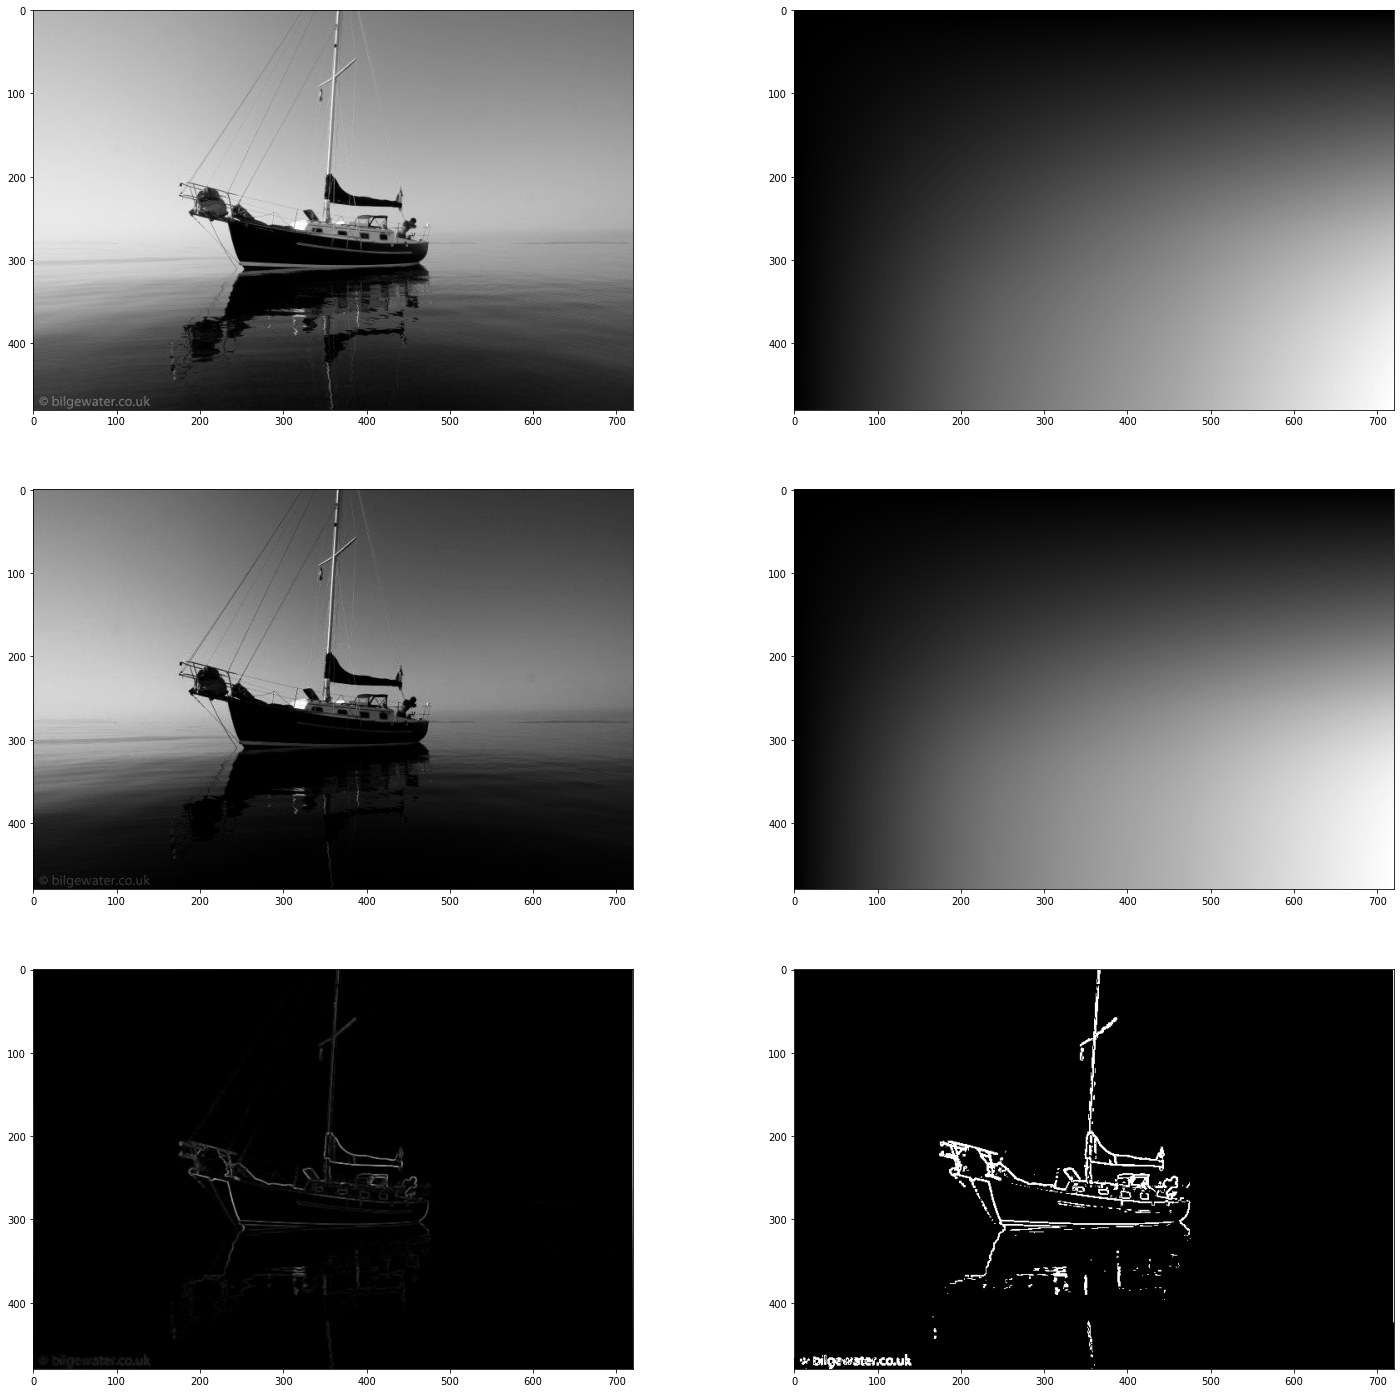

In [ ]:

#plt has to be imported, see the previous sections
plt.subplots(nrows=3, ncols=2, figsize=(25, 25))

plt.subplot(3,2,1)
plt.imshow(image1,  cmap = 'gray')

plt.subplot(3,2,2)
plt.imshow(image2,  cmap = 'gray')

plt.subplot(3,2,3)
plt.imshow(image3,  cmap = 'gray')

plt.subplot(3,2,4)
plt.imshow(image4,  cmap = 'gray')

plt.subplot(3,2,5)
plt.imshow(image5,  cmap = 'gray')

plt.subplot(3,2,6)
plt.imshow(image6,  cmap = 'gray')

# Comments

#consider the input image is of size (m x n)



# Task 1 :
1) Calculating the co-occurrence matrices: O(m x n) where n is the height of the image and m is the width of the image.
--
2) Nullifying the matrix: O(255 X 255) where 255 is the number of colors and since we know that the number of colors of a gray image (the input) is 255 it is considered a constant and it is O(1).
--
3) Producing the new image: O(m x n)  because we are looping on every pixel of the image and checking if it should be a zero or a one.
--






# Task 2 :
Complexity: 
---
 1) toArray and square function  O(m x n)
 --
 2) IntegralArray O(m x n)
 --
 3) LocalSum O(1)
 ---
 4) imgwithIntegral O(m x n) 
 ---
 5) applyThreshold O(m x n)
 ---
 functions implemented have a complexity of O(m x n) for (toArray and square function)+ 2*O(m x n) for (implementing IntegralArray function 2 times) + O(m x n) for (imgwithIntegral) + O(m x n) for (applyThreshold) = 5 * O(m x n) 

 so complexity = O (m x n) where m is the number of rows in image and n is number of columns.
--

# Efficiency and Comparing the Outputs::
Both algorithms can identify edges. However, the second algorithm performed better in identifying the edges of the ship, whereas the first algorithm added more noise to the image.
---
In conclusion, task 2 is better in computing the edges because the variance takes into consideration a window of pixels. However, the cooccurrence matrix takes into consideration the east and the south pixels only
---
Also, both images have the same complexity
--



